12 minutes: minute by minute breakdown as follows
1. Introduction to the problem
2. Contents
3. Autodiff and our GradPy package 
4. What is IMRT
5. The therapyplanner package
6. Demo
7. Demo
8. Demo
9. Demo
10. Summary
12. Future Directions

Run the presentation with 
jupyter nbconvert FinalPresentation.ipynb --to slides --post serve

# CS207 Project Presentation

### Jovana Andrejevic, Jay Li, Queena Zhou, Gopal Kotecha

# Introduction to the problem

This is Jerry.  Jerry works in government.

![title](pics/jerry.jpg)

## Jerry Brown (Dem), CA

Jerry went to his doctor for a routine blood test, and his doctor found a raised PSA (Prostate Specific Antigen).  This turned out to be a case of prostate cancer, for which Jerry received radiotherapy.  

# Today's talk
1. Automatic differentiation and our GradPy package
2. The use case: IMRT
3. The therapyplanner package
4. Demo
5. Summary
6. Future Directions

# Automatic Differentiation

- A technique for computing derivatives of functions that is distinct from both symbolic and numerical differentiation.
- Primary advantage: can handle complicated functions without sacrificing the accuracy of the computed derivative.

We have implemented automatic differentiation with the package **`gradpy`**:
- supports automatic differentiation of univariate and multivariate, single or vector-valued functions
- provides elementary operations as well as commonly used functions such as exponential, trigonometric, hyperbolic, logarithm, square root, and logistic.

## By hand ...

$$
\begin{align}
f(x,y) &= \log \left[1+\exp\left(\sqrt{\sin^2x-\cos^2y}\right)\right] \\
\dfrac{\partial{f}}{\partial{x}} &= \dfrac{1}{1+\exp\left(\sqrt{\sin^2x-\cos^2y}\right)}\exp\left(\sqrt{\sin^2x-\cos^2y}\right)\dfrac{1}{\sqrt{\sin^2x-\cos^2y}}\sin{x}\cos{x} \\
\dfrac{\partial{f}}{\partial{y}} &= \dfrac{1}{1+\exp\left(\sqrt{\sin^2x-\cos^2y}\right)}\exp\left(\sqrt{\sin^2x-\cos^2y}\right)\dfrac{1}{\sqrt{\sin^2x-\cos^2y}}\cos{y}\sin{y}
\end{align}
$$

$$
\nabla{f}\left(\dfrac{\pi}{6},\dfrac{\pi}{2}\right) \approx \left[0.53906, 0\right]
$$

## With `gradpy` ...

In [1]:
import numpy as np
from gradpy.autodiff import Var
from gradpy.math import Log, Exp, Sqrt, Sin, Cos

# Create independent variables and user-defined function:
x = Var()
y = Var()

f = Log(1+Exp(Sqrt((Sin(x))**2-(Cos(y))**2)))

# Assign values, if not initialized:
x.set_value(np.pi/6)
y.set_value(np.pi/2)

# Obtain the derivative with respect to each variable, or the complete gradient:
print(f.der(x), f.der(y))
print(f.grad([x,y]))

0.5390655936434777 7.622928275557534e-17
[5.39065594e-01 7.62292828e-17]


## Support for vector-valued functions:

In [2]:
from gradpy.autodiff import Array

x = Var(3)
y = Var(2)
z = Var(1)

v = Array([-y - z,
           x + 0.1*y,
           0.1 + z*(x - 14)])

# concisely obtain the full Jacobian:
print(v.grad([x,y,z]))

[[  0.   -1.   -1. ]
 [  1.    0.1   0. ]
 [  1.    0.  -11. ]]


... is equivalent to:

In [3]:
print(np.array([v[0].grad([x,y,z]),
                v[1].grad([x,y,z]),
                v[2].grad([x,y,z])]))

[[  0.   -1.   -1. ]
 [  1.    0.1   0. ]
 [  1.    0.  -11. ]]


... is equivalent to:

In [4]:
print(np.array([[v[0].der(x), v[0].der(y), v[0].der(z)],
                [v[1].der(x), v[1].der(y), v[1].der(z)],
                [v[2].der(x), v[2].der(y), v[2].der(z)]]))

[[  0.   -1.   -1. ]
 [  1.    0.1   0. ]
 [  1.    0.  -11. ]]


# Application: Intensity Modulated Radiation Therapy (IMRT)

- What is IMRT?
- Why is it well-suited for automatic differentiation?

## What is IMRT?
- Intensity Modulated Radiation Therapy (IMRT) is a technique for optimizing radiation dose delivery for cancer treatment.
- The objective of IMRT is the precise irradiation of a defined tumor region while minimizing radiation exposure to adjacent organs and healthy tissue.
![title](pics/map.png)

- The region is irradiated from different directions, here with one beam propagating horizontally to the right, and another propagating vertically down.
- Beam collimators adjust to limit and control the regions exposed to radiation over the course of the treatment, allowing for non-uniform dose distribution delivery.
![title](pics/beams1.png)

- The region is irradiated from different directions, here with one beam propagating horizontally to the right, and another propagating vertically down.
- Beam collimators adjust to limit and control the regions exposed to radiation over the course of the treatment, allowing for non-uniform dose distribution delivery.
![title](pics/beams2.png)

## Reframed optimization problem
- Rather than optimize the sequence of collimator apertures directly, IMRT solves a reframed optimization problem.
- A non-uniform dose distribution can equivalently be obtained by considering each beam as comprised of independently controlled beamlets:

![title](pics/reframed.png)

$$
\begin{align}
& m + n \text{ beamlets} \\
& m \times n \text{ target doses} \\
\end{align}
$$

$$
\begin{align}
& m + n \text{ beamlets} \\
& m \times n \text{ target doses} \\
\end{align}
$$

The delivered dose at each grid position can be expressed as

$$
D_{(m\times{n})\times{1}} = A_{(m\times{n})\times{(m+n)}}B_{(m+n)\times{1}}
$$

- $D$: Delivered dose
- $A$: Intensity attenuation matrix: position-dependent factors $e^{-\mu{x}}$
- $B$: Beamlet source intensities to optimize

## Cost function
The task of finding the optimal beamlet source intensities is formulated as the minimization of a cost function $C$:

$$
C = \sum_{i=1}^{m\times{n}} \left(d_i-d_i^{target}\right)^2 + \sum_{i=1}^{m\times{n}} \left[\sigma\left(d_i-d_i^{max}\right) + \sigma\left(d_i^{min}-d_i\right)\right] + \sum_{j=1}^{m+n} \sigma\left(-b_j\right)
$$

#### Key contributions:
- mean squared error from target dose
- penalty for doses outside specified maximum and minimum values
- penalty for a solution reporting negative beamlet intensities

A continuous penalty function is formulated as the **logistic function** $\sigma$ with tunable smoothness parameter.

## Optimization with automatic differentiation
- IMRT relies on precise gradients of complex, multivariate cost functions, and is thus a well-suited problem for automatic differentiation.
- Minimization of the cost function is performed using the **Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm** implemented with automatic differentiation.

#### Motivation for BFGS:
- A Quasi-Newton method - Unlike the full Newton's method, no second are derivatives needed; BFGS builds up an approximation of the Hessian.
- No need to perform a large, iterative solve of a system of equations
- As a result, computationally more efficient

# The **`therapy_planner`** package

- solves dose optimization problems in 2D
- ships with `gradpy`; automatically installed and used "under-the-hood"
- user-friendly interface for data input, optimization, and built-in visualization
- though an introductory package, it flexibly handles missing data, allows users to adjust the stringency of optimization criteria, and optionally optimizes over different orientations of the target region.

# Radiation therapy optimization demo

In this demo, we illustrate a few simple examples of plan optimization for radiation therapy.

In [5]:
import sys
sys.path.append("../../therapy_planner")

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from therapy_planner.interface import PlannerInterface
import numpy as np

The user begins by creating a plan through the `PlannerInterface` Class by supplying an input file of the target, maximum, and minimum radiation doses (Gy) to be delivered to an $m\times{n}$ [cm$^2$] region. Here we get the target, max, and min maps, and visualize the specified doses.

In [7]:
plan = PlannerInterface("dose_4x3.map")

## Anatomy of an input file

### **`dose_4x3.map`**:
![title](pics/input.png)

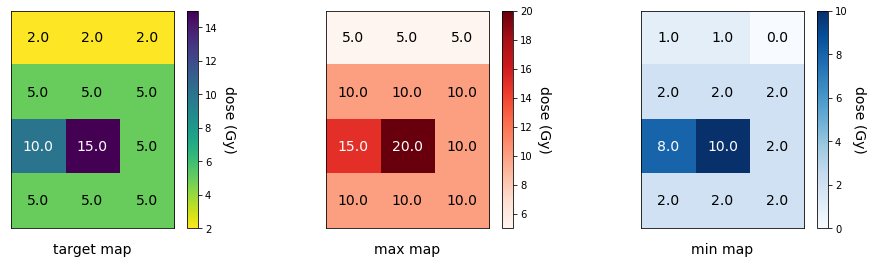

In [8]:
maps = plan.get_maps()

fig, axes = plt.subplots(1,3,figsize=(16,4))
cmaps = ["viridis_r", "Reds", "Blues"]
for key, ax, cmap in zip(maps.keys(),axes.flat,cmaps):
    plan.plot_map(key, ax, cmap)
plt.show()

Next we run the `optimize` method of the `PlannerInterface` Class outlined in the `interface` module. The required input is the incident beam intensity, in mW, of the horizontal and vertical beams, which is used to optimize two quantities:
1. horizontal and vertical beam exposure times
2. sequence of collimator apertures for each beam, adjusted over the course of exposure, to tune the amount of radiation delivered to specific regions.

By setting `bounds=True`, we include a penalty term for optimized dose maps whose values lie outside of the provided minimum and maximum values.

Minimum found.
Time Elapsed: 0.8511 sec.


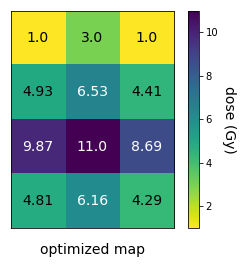

In [9]:
plan.optimize(intensity=1., bounds=True, smoothness=0.5)
plan.plot_map("optimized")

The `print_summary()` method prints a summary of several useful aspects of the optimized plan:

In [10]:
plan.print_summary()

Horizontal beam intensity: 1.00 mW/cm^2
Horizontal beam exposure time: 9 sec.
Vertical beam intensity: 1.00 mW/cm^2
Vertical beam exposure time: 3 sec.
Total accumulated dose: 65.69 Gy
Average dose per unit area: 5.47 Gy/cm^2



Below we visualize the adjustment of the collimator apertures over the course of the exposure time to achieve the desired dose. For example, we can observe that the second slot of the vertical beam collimator remains exposed to radiation over the full exposure time, and is in fact the column which receives the highest dose.

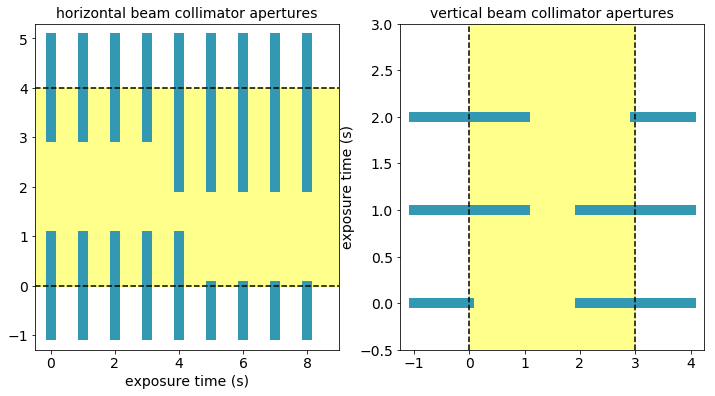

In [11]:
plan.plot_collimators()

We can also allow rotation of the maps in order to achieve minimum cost among all 4 rotations, by setting `allow_rotation` to `True`.

Optimize for rotation: 0 degrees
Minimum found.
Negative beamlet value detected. Suggestion: Adjust the smoothness.
Optimize for rotation: 90 degrees
Minimum found.
Negative beamlet value detected. Suggestion: Adjust the smoothness.
Optimize for rotation: 180 degrees
Minimum found.
Optimize for rotation: 270 degrees
Minimum found.
Found best rotation (counter-clockwise): 270 degrees
Time Elapsed: 2.6361 sec.


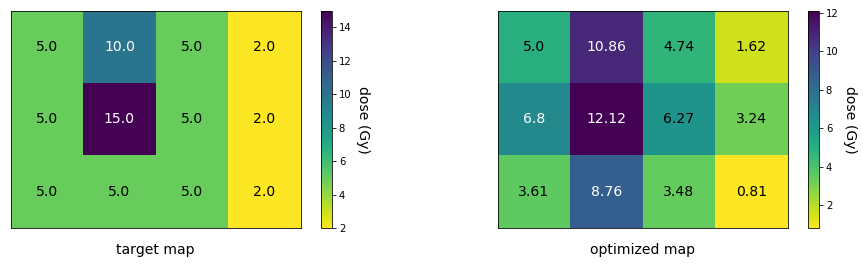

In [12]:
plan.optimize(intensity=1., bounds=True, allow_rotation=True)
fig, axes = plt.subplots(1,2,figsize=(16,4))
plan.plot_map("target", axes[0])
plan.plot_map("optimized", axes[1])
plt.show()

The input maps may also have missing values, as shown in the modified example below. The `optimize` routine will obtain the best solution using only the available constraints.

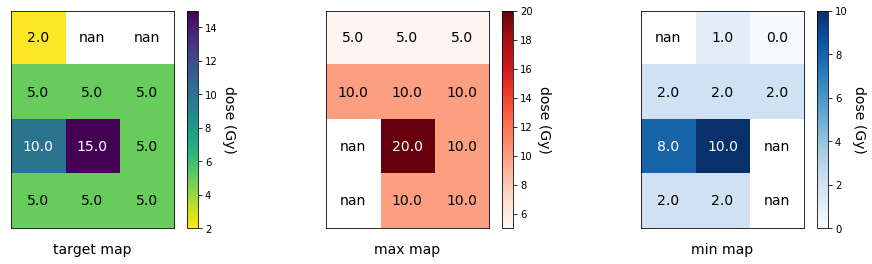

In [13]:
plan = PlannerInterface("dose_4x3_NaN.map")
maps = plan.get_maps()

fig, axes = plt.subplots(1,3,figsize=(16,4))
cmaps = ["viridis_r", "Reds", "Blues"]
for key, ax, cmap in zip(maps.keys(),axes.flat,cmaps):
    plan.plot_map(key, ax, cmap)
plt.show()

Optimize for rotation: 0 degrees
Minimum found.
Optimize for rotation: 90 degrees
Minimum found.
Negative beamlet value detected. Suggestion: Adjust the smoothness.
Optimize for rotation: 180 degrees
Minimum found.
Optimize for rotation: 270 degrees
Minimum found.
Found best rotation (counter-clockwise): 270 degrees
Time Elapsed: 2.4240 sec.


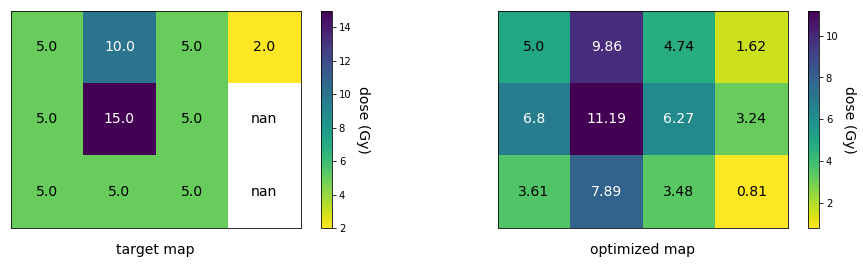

In [14]:
plan.optimize(intensity=1., bounds=True, allow_rotation=True)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plan.plot_map("target", axes[0])
plan.plot_map("optimized", axes[1])
plt.show()

As a final example, we next test a larger map:

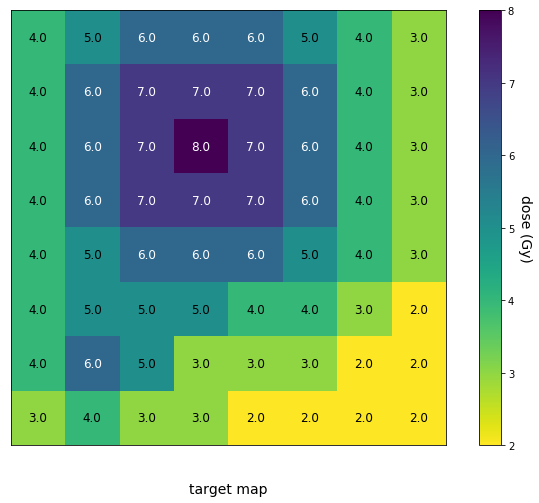

In [15]:
plan = PlannerInterface("dose_8x8.map")
plan.plot_map("target",fontsize=12)

Minimum found.
Time Elapsed: 28.7099 sec.


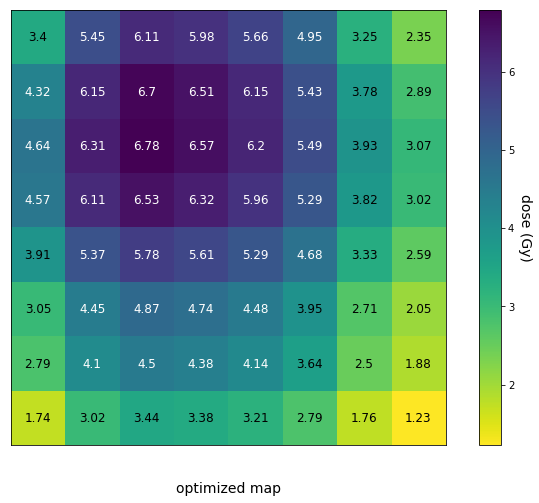

In [16]:
plan.optimize(intensity=0.2, bounds=True)
plan.plot_map("optimized", fontsize=12)

We can also plot the difference between the optimized dose map and the target map to highlight over and underdosed regions, as well as the error (magnitude of the difference plot).

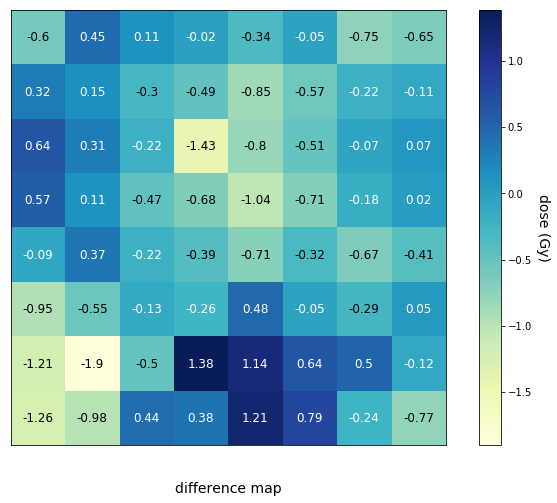

In [17]:
plan.plot_map("difference", cmap='YlGnBu', fontsize=12)

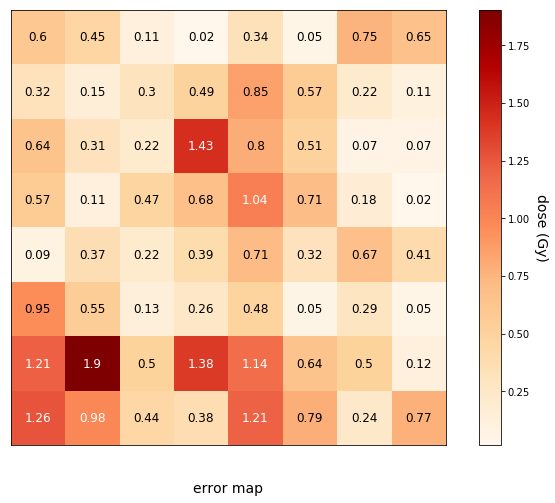

In [18]:
plan.plot_map("error", cmap='OrRd', fontsize=12)

# Summary and evaluation

- We have created a library that implements automatic differentiation.
- We have applied this library to an interesting optimization use-case.  
- We have reached a sophisticated modelling level beyond that of "toy-problem".
- There is still some way to go to make it a clinically useable/shippable tool.

# Future directions
- 3 dimensional
- Multiple maps
- Continue to make simulation realistic
- Front end
- Speak to users and write a full product requirements document/specification